# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np
import random

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# Set random seeds
def setAllRandomSeeds(environment, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    environment.seed(seed)
setAllRandomSeeds(env, seed=420)

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
'''
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()
        #env.close()
'''

'\nenv.reset()\nrewards = []\nfor _ in range(100):\n    env.render()\n    state, reward, done, info = env.step(env.action_space.sample()) # take a random action\n    rewards.append(reward)\n    if done:\n        rewards = []\n        env.reset()\n        #env.close()\n'

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
#print(rewards[-20:])

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 700          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000*10         # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

Instructions for updating:
Use the retry module or similar alternatives.


## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      #'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward, step))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 1.0 Explore P: 0.9999
Episode: 2 Total reward: 20.0 Explore P: 0.9979
Episode: 3 Total reward: 11.0 Explore P: 0.9968
Episode: 4 Total reward: 43.0 Explore P: 0.9926
Episode: 5 Total reward: 13.0 Explore P: 0.9913
Episode: 6 Total reward: 25.0 Explore P: 0.9889
Episode: 7 Total reward: 32.0 Explore P: 0.9857
Episode: 8 Total reward: 18.0 Explore P: 0.9840
Episode: 9 Total reward: 13.0 Explore P: 0.9827
Episode: 10 Total reward: 29.0 Explore P: 0.9799
Episode: 11 Total reward: 25.0 Explore P: 0.9775
Episode: 12 Total reward: 20.0 Explore P: 0.9756
Episode: 13 Total reward: 48.0 Explore P: 0.9709
Episode: 14 Total reward: 9.0 Explore P: 0.9701
Episode: 15 Total reward: 19.0 Explore P: 0.9682
Episode: 16 Total reward: 20.0 Explore P: 0.9663
Episode: 17 Total reward: 19.0 Explore P: 0.9645
Episode: 18 Total reward: 39.0 Explore P: 0.9608
Episode: 19 Total reward: 15.0 Explore P: 0.9594
Episode: 20 Total reward: 14.0 Explore P: 0.9580
Episode: 21 Total reward: 15.0 

Episode: 171 Total reward: 31.0 Explore P: 0.7422
Episode: 172 Total reward: 15.0 Explore P: 0.7411
Episode: 173 Total reward: 18.0 Explore P: 0.7398
Episode: 174 Total reward: 22.0 Explore P: 0.7381
Episode: 175 Total reward: 33.0 Explore P: 0.7357
Episode: 176 Total reward: 16.0 Explore P: 0.7346
Episode: 177 Total reward: 10.0 Explore P: 0.7339
Episode: 178 Total reward: 11.0 Explore P: 0.7331
Episode: 179 Total reward: 35.0 Explore P: 0.7305
Episode: 180 Total reward: 14.0 Explore P: 0.7295
Episode: 181 Total reward: 19.0 Explore P: 0.7282
Episode: 182 Total reward: 22.0 Explore P: 0.7266
Episode: 183 Total reward: 13.0 Explore P: 0.7257
Episode: 184 Total reward: 19.0 Explore P: 0.7243
Episode: 185 Total reward: 26.0 Explore P: 0.7224
Episode: 186 Total reward: 10.0 Explore P: 0.7217
Episode: 187 Total reward: 11.0 Explore P: 0.7210
Episode: 188 Total reward: 11.0 Explore P: 0.7202
Episode: 189 Total reward: 25.0 Explore P: 0.7184
Episode: 190 Total reward: 10.0 Explore P: 0.7177


Episode: 338 Total reward: 15.0 Explore P: 0.5413
Episode: 339 Total reward: 41.0 Explore P: 0.5391
Episode: 340 Total reward: 31.0 Explore P: 0.5375
Episode: 341 Total reward: 54.0 Explore P: 0.5346
Episode: 342 Total reward: 30.0 Explore P: 0.5331
Episode: 343 Total reward: 49.0 Explore P: 0.5305
Episode: 344 Total reward: 35.0 Explore P: 0.5287
Episode: 345 Total reward: 104.0 Explore P: 0.5233
Episode: 346 Total reward: 49.0 Explore P: 0.5208
Episode: 347 Total reward: 40.0 Explore P: 0.5188
Episode: 348 Total reward: 57.0 Explore P: 0.5159
Episode: 349 Total reward: 89.0 Explore P: 0.5114
Episode: 350 Total reward: 43.0 Explore P: 0.5092
Episode: 351 Total reward: 14.0 Explore P: 0.5086
Episode: 352 Total reward: 46.0 Explore P: 0.5063
Episode: 353 Total reward: 58.0 Explore P: 0.5034
Episode: 354 Total reward: 41.0 Explore P: 0.5014
Episode: 355 Total reward: 26.0 Explore P: 0.5001
Episode: 356 Total reward: 46.0 Explore P: 0.4978
Episode: 357 Total reward: 50.0 Explore P: 0.4954

Episode: 502 Total reward: 117.0 Explore P: 0.2023
Episode: 503 Total reward: 137.0 Explore P: 0.1997
Episode: 504 Total reward: 55.0 Explore P: 0.1987
Episode: 505 Total reward: 135.0 Explore P: 0.1962
Episode: 506 Total reward: 136.0 Explore P: 0.1936
Episode: 507 Total reward: 199.0 Explore P: 0.1900
Episode: 508 Total reward: 110.0 Explore P: 0.1881
Episode: 509 Total reward: 99.0 Explore P: 0.1863
Episode: 510 Total reward: 126.0 Explore P: 0.1841
Episode: 511 Total reward: 45.0 Explore P: 0.1833
Episode: 512 Total reward: 62.0 Explore P: 0.1822
Episode: 513 Total reward: 79.0 Explore P: 0.1809
Episode: 514 Total reward: 99.0 Explore P: 0.1792
Episode: 515 Total reward: 84.0 Explore P: 0.1778
Episode: 516 Total reward: 85.0 Explore P: 0.1764
Episode: 517 Total reward: 65.0 Explore P: 0.1753
Episode: 518 Total reward: 176.0 Explore P: 0.1724
Episode: 519 Total reward: 133.0 Explore P: 0.1703
Episode: 520 Total reward: 107.0 Explore P: 0.1686
Episode: 521 Total reward: 80.0 Explore 

Episode: 663 Total reward: 199.0 Explore P: 0.0207
Episode: 664 Total reward: 199.0 Explore P: 0.0205
Episode: 665 Total reward: 199.0 Explore P: 0.0203
Episode: 666 Total reward: 199.0 Explore P: 0.0201
Episode: 667 Total reward: 199.0 Explore P: 0.0199
Episode: 668 Total reward: 199.0 Explore P: 0.0197
Episode: 669 Total reward: 199.0 Explore P: 0.0195
Episode: 670 Total reward: 199.0 Explore P: 0.0193
Episode: 671 Total reward: 199.0 Explore P: 0.0191
Episode: 672 Total reward: 199.0 Explore P: 0.0190
Episode: 673 Total reward: 199.0 Explore P: 0.0188
Episode: 674 Total reward: 199.0 Explore P: 0.0186
Episode: 675 Total reward: 199.0 Explore P: 0.0184
Episode: 676 Total reward: 199.0 Explore P: 0.0183
Episode: 677 Total reward: 199.0 Explore P: 0.0181
Episode: 678 Total reward: 199.0 Explore P: 0.0179
Episode: 679 Total reward: 199.0 Explore P: 0.0178
Episode: 680 Total reward: 199.0 Explore P: 0.0176
Episode: 681 Total reward: 199.0 Explore P: 0.0175
Episode: 682 Total reward: 199.

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [12]:
#%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

## Testing

Let's checkout how our trained agent plays the game.

(699, 2)


Text(0,0.5,'Total Reward')

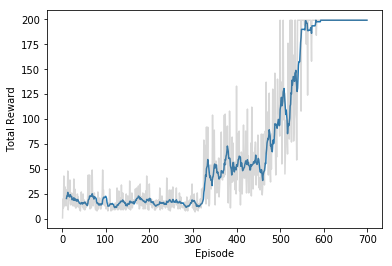

In [13]:
eps, rews, steps = np.array(rewards_list).T
eps = np.reshape(eps, [-1,1])
rews = np.reshape(rews, [-1,1])
steps = np.reshape(steps, [-1,1])
out_array = np.concatenate((steps, rews),axis=1)
print(out_array.shape)
# Output rewards per episode
np.savetxt("rew_orig.dat", out_array, fmt="%d")

smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


KeyboardInterrupt: 

In [ ]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.